In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split


In [11]:
# Load CSV
df = pd.read_csv("DWLR_Dataset_2023.csv")

# Clean column names
df.columns = df.columns.str.strip().str.replace('#','').str.replace(' ','_')

# Preview
print(df.head())
print(df.info())


         Date  Water_Level_m  Temperature_C  Rainfall_mm        pH  \
0  2023-01-01       2.124836      -0.601831    26.958453  6.948386   
1  2023-01-02       2.099955       0.396578    15.306932  6.952946   
2  2023-01-03       2.146121       0.139768    29.263846  6.912783   
3  2023-01-04       2.196756       0.327833     8.246142  6.972447   
4  2023-01-05       2.115765      -0.917756    35.654194  6.962424   

   Dissolved_Oxygen_mg_L  
0               8.282231  
1               7.998230  
2               8.173989  
3               8.079537  
4               8.425726  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   365 non-null    object 
 1   Water_Level_m          365 non-null    float64
 2   Temperature_C          365 non-null    float64
 3   Rainfall_mm            365 non-null    float64
 

In [12]:
# Convert date column
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Fill missing values (Dissolved Oxygen had some NaNs)
df = df.ffill()

# Feature engineering
df['Month'] = df['Date'].dt.month
df['DayOfYear'] = df['Date'].dt.dayofyear

# Quick check
print(df.head())
print(df.info())


        Date  Water_Level_m  Temperature_C  Rainfall_mm        pH  \
0 2023-01-01       2.124836      -0.601831    26.958453  6.948386   
1 2023-01-02       2.099955       0.396578    15.306932  6.952946   
2 2023-01-03       2.146121       0.139768    29.263846  6.912783   
3 2023-01-04       2.196756       0.327833     8.246142  6.972447   
4 2023-01-05       2.115765      -0.917756    35.654194  6.962424   

   Dissolved_Oxygen_mg_L  Month  DayOfYear  
0               8.282231      1          1  
1               7.998230      1          2  
2               8.173989      1          3  
3               8.079537      1          4  
4               8.425726      1          5  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   365 non-null    datetime64[ns]
 1   Water_Level_m          365 no

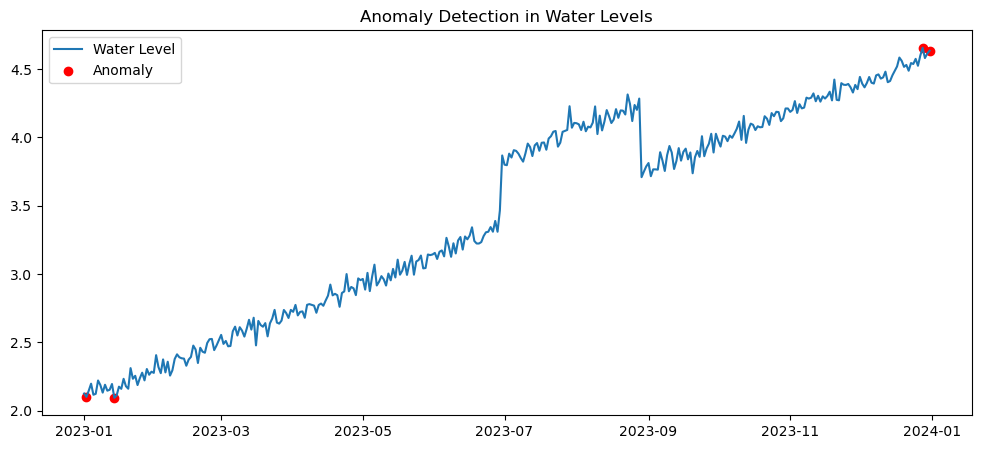

In [13]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Isolation Forest for anomaly detection
iso = IsolationForest(contamination=0.01, random_state=42)
df['anomaly'] = iso.fit_predict(df[['Water_Level_m']])

# Plot anomalies
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Water_Level_m'], label='Water Level')
plt.scatter(df['Date'][df['anomaly'] == -1],
            df['Water_Level_m'][df['anomaly'] == -1],
            color='red', label='Anomaly')
plt.legend()
plt.title("Anomaly Detection in Water Levels")
plt.show()


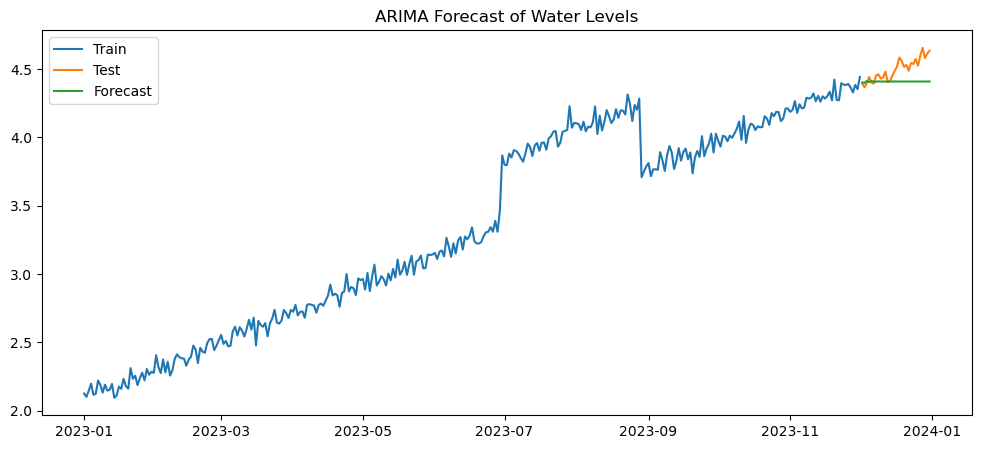

MAE: 0.09336508054626463
RMSE: 0.11771417476987785


In [14]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Use the correct column name
series = df.set_index('Date')['Water_Level_m']
series = series.asfreq('D') 

# Train-test split (last 30 days as test)
train = series.iloc[:-30]
test = series.iloc[-30:]

# Fit ARIMA model
model = ARIMA(train, order=(5,1,0))  # you can tune order later
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=30)

# Plot results
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.title("ARIMA Forecast of Water Levels")
plt.show()

# Accuracy
print("MAE:", mean_absolute_error(test, forecast))
print("RMSE:", np.sqrt(mean_squared_error(test, forecast)))


Random Forest MAE: 0.27980185857437895
Random Forest RMSE: 0.31460162463203173


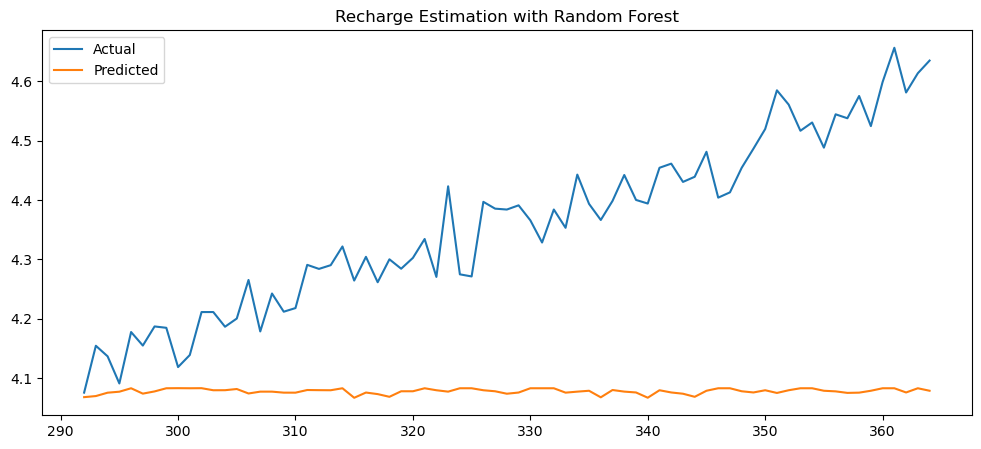

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Features and target
features = ['Rainfall_mm', 'Temperature_C', 'pH', 'Dissolved_Oxygen_mg_L', 'Month', 'DayOfYear']
X = df[features]
y = df['Water_Level_m']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Plot predictions
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.title("Recharge Estimation with Random Forest")
plt.show()


In [16]:
# =========================
# 8. Decision Support: Generate Text Insights
# =========================

# --- Groundwater Level Status ---
latest_level = df['Water_Level_m'].iloc[-1]

if latest_level < 1:
    level_status = "🚨 Groundwater level is critically low."
elif 1 <= latest_level < 3:
    level_status = "⚠️ Groundwater level is below average, monitor closely."
else:
    level_status = "✅ Groundwater level is stable."

# --- Recharge Status (compare last actual vs last predicted) ---
predicted_next = y_pred[-1]   # last Random Forest prediction
actual_last = y_test.iloc[-1]

if predicted_next > actual_last:
    recharge_status = "🌧️ Groundwater recharge is improving after recent rainfall."
else:
    recharge_status = "⚠️ Recharge rate is low, risk of depletion ahead."

# --- Anomaly Alerts ---
anomalies = df[df['anomaly'] == -1]

if len(anomalies) > 0:
    anomaly_status = f"⚠️ {len(anomalies)} anomaly points detected in sensor data."
else:
    anomaly_status = "✅ No anomalies detected in DWLR readings."

# --- Print All Insights ---
print("🔎 AI Insights:")
print(level_status)
print(recharge_status)
print(anomaly_status)


🔎 AI Insights:
✅ Groundwater level is stable.
⚠️ Recharge rate is low, risk of depletion ahead.
⚠️ 4 anomaly points detected in sensor data.


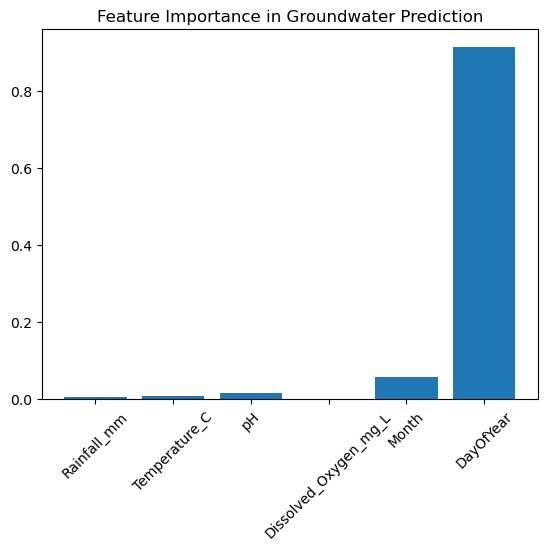

In [17]:
importances = rf.feature_importances_
plt.bar(features, importances)
plt.title("Feature Importance in Groundwater Prediction")
plt.xticks(rotation=45)
plt.show()


In [18]:
print("✅ Prototype complete: Anomaly Detection + Forecasting + Recharge Estimation")


✅ Prototype complete: Anomaly Detection + Forecasting + Recharge Estimation


In [19]:
import joblib
joblib.dump(rf, "random_forest_model.pkl")
joblib.dump(model_fit, "arima_model.pkl")


['arima_model.pkl']